In [1]:
import os
from pathlib import Path

import qcodes
from qcodes.dataset import (
    LinSweep,
    TogetherSweep,
    do1d,
    do2d,
    dond,  
    Measurement,
    load_or_create_experiment,
    plot_dataset,
    initialise_or_create_database_at
)

import numpy as np

import scipy

import time

import matplotlib.pyplot as plt

## Measuring Current Pre-Amp Bias

In [2]:
# Load in Station
station = qcodes.Station(config_file='../station_config.yml')
station.load_instrument('sim900')
station.load_instrument('agilent')

Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.76s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.10s


<Agilent34401A: agilent>

In [ ]:
preamp_bias_exp = load_or_create_experiment('Current PreAmp-2 Bias Experiment', sample_name='10MOhm Resistor')

In [ ]:
VI_sweep = Measurement(exp=preamp_bias_exp)

In [ ]:
# Record independent variable
VI_sweep.register_parameter(station.sim900.volt_1)
# Record dependent variable (setpoints implies dependency)
VI_sweep.register_parameter(station.agilent.volt, setpoints=[station.sim900.volt_1])

dV = 1e-3 # min resolution
volt_min, volt_max = -10e-3, 10e-3
voltage_sweep = np.arange(volt_min, volt_max, dV) # sweep values
station.sim900.set_smooth({1: volt_min}) # smoothly ramp to start point

with VI_sweep.run() as datasaver:
    for voltage in voltage_sweep:
        station.sim900.volt_1.set(voltage) # set voltage (mV)
        datasaver.add_result(
            (station.sim900.volt_1, station.sim900.volt_1()),
            (station.agilent.volt, station.agilent.volt())
            ) # record measurement
        
station.sim900.set_smooth({1: 0}) # smoothly ramp to 0V after measurement
dataset = datasaver.dataset

In [ ]:
df = dataset.to_pandas_dataframe().reset_index()

df_current = df.copy()
df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
df_current.iloc[:,1] = df_current.iloc[:,1].mul(-1e-6) # sensitivity

V = df_current['sim900_volt_1'] # V
I = df_current['agilent_current'] # A

def linear(x, m, b):
    return m * x + b

fit_params, pcov = scipy.optimize.curve_fit(linear, xdata=V, ydata=I, p0=(1, 0))

G, IBias = fit_params

R = 1/G

print("Resistance is {:3f} M\u03A9".format(R/1e6))
print("Y-Intercept is (0 mV, {:3f} nA)".format(IBias/1e-9))
print("X-Intercept is ({:3f} mV, 0 nA)".format((-IBias/G) / 1e-3))

axes = df_current.plot.scatter(y='agilent_current', x='sim900_volt_1', linewidth=1, s=20, label=r'$I_{\text{RAW}}$')
axes.axhline(y=0, color='k', alpha=0.25, linestyle='--')
axes.axvline(x=0, color='k', alpha=0.25, linestyle='--')
axes.scatter([0],[IBias], s=45, marker='x', c='r', label='Current Bias: {:.3f} nA'.format(IBias/1e-9))
axes.set_ylabel(r'$I$ (A)')
axes.set_xlabel(r'$V_{\text{SIM900}}$ (V)')
axes.set_title('CSG Current PreAmp-2 Bias')

df_current_nobias = df_current.copy()
# subtract the bias
df_current_nobias.iloc[:,1] = df_current_nobias.iloc[:,1].subtract(IBias)
axes.scatter(df_current_nobias['sim900_volt_1'], df_current_nobias['agilent_current'], color='k', s=20, label=r'$I_{\text{CORRECTED}}$')
axes.legend(loc='best')

## 0. Set-up the Dataset

In [3]:
def exp_fit(x, a, b, x0, y0):
    return a * np.exp(b * (x-x0)) + y0

def sigmoid_fit(x, a, b, x0, y0):
    return a/(1+np.exp(b * (x-x0))) + y0

In [4]:
import datetime
# Initialize or create the database at the specified path
# Generate today's date in the format YYYY-MM-DD
today_date = datetime.date.today().strftime("%Y-%m-%d")
initialise_or_create_database_at(f"~/experiments_{today_date}.db")

In [5]:
initialization_exp = load_or_create_experiment('Initialization Experiment', sample_name='SHT 2AB')

In [6]:
station.sim900.set_smooth({
    'S': 0,
    'LB': 0,
    'RB': 0,
    'STR':0
})
station.sim900.print_readable_snapshot()

sim900:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM900', ...
IDN_7           :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_8           :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_LB          :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_P           :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_RB          :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_S           :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_STL         :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
IDN_STR         :	{'vendor': 'Stanford_Research_Systems', 'model': 'SIM928', ...
smooth_timestep :	1 (s)
timeout         :	10 (s)
volt_7          :	0 (V)
volt_7_step     :	0.005 (V)
volt_8          :	0 (V)
volt_8_step     :	0.005 (V)
volt_LB

In [7]:
device_info = {}

In [22]:
station.sim900.set_smooth({
    'S': 0,
    'LB': 0,
    'RB': 0,
    'STR':0
})

In [12]:
# Bias the device
station.sim900.set_smooth({
    'LB': 0,
    'RB': 0,
    'STR': 0
})

sensitivity = 1e-5 # A/V

# ASSUMING YOU HAVE SOME SORT OF VOLTAGE DIVIDER!!
VBias = -7 # V

min_current_threshold = 0.5e-9
max_current_threshold = 2e-9

station.sim900.set_smooth({'S': VBias})

IBias = 1.5e-9 # A

In [13]:
print(min_current_threshold)

2.2901550000000003e-09


## 1. Global Turn On

Starting experimental run with id: 14. Using 'qcodes.dataset.dond'
     sim900_volt_STR  sim900_volt_LB  sim900_volt_RB  agilent_volt
0               0.00            0.00            0.00      0.000153
1              -0.01           -0.01           -0.01      0.000154
2              -0.02           -0.02           -0.02      0.000154
3              -0.03           -0.03           -0.03      0.000155
4              -0.04           -0.04           -0.04      0.000153
..               ...             ...             ...           ...
115            -1.15           -1.15           -1.15      0.000514
116            -1.16           -1.16           -1.16      0.000511
117            -1.17           -1.17           -1.17      0.000512
118            -1.18           -1.18           -1.18      0.000508
119            -1.19           -1.19           -1.19      0.000511

[120 rows x 4 columns]


An exception occurred in measurement with guid: 0f7012e5-0000-0000-0000-018dfb779686;
Traceback:
Traceback (most recent call last):
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\dataset\dond\do_nd.py", line 732, in dond
    results[set_event.parameter] = set_event.parameter()
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\parameters\parameter_base.py", line 462, in __call__
    return self.get()
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\parameters\parameter_base.py", line 675, in get_wrapper
    raise e
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\parameters\parameter_base.py", line 662, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\parameters\command.py", line 209, in __call__
    return self.exec_function(*ar

Turn on:  -0.39 V
Saturation Voltage:  -1.19 V
Global Turn On Distance:  -0.7999999999999999 V


VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', 'getting sim900_volt_RB')

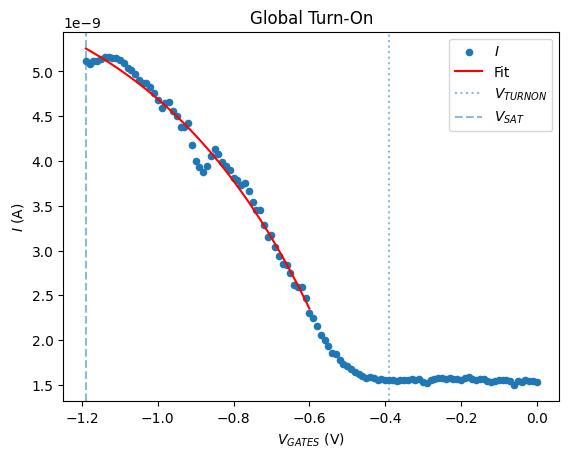

In [14]:
def fit_data():

    # Get last dataset (presumably the last measurement done) and convert from voltage to current values
    dataset = qcodes.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()
    print(df)
    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(sensitivity).subtract(IBias) # sensitivity

    # Plot current v.s. random gate (since they are swept together)
    axes = df_current.plot.scatter(y='agilent_current', x='sim900_volt_LB', linewidth=1, s=20, label=r'$I$')
    axes.set_ylabel(r'$I$ (A)')
    axes.set_xlabel(r'$V_{GATES}$ (V)')
    axes.set_title('Global Turn-On')

    # Start fitting relevant current to extract turn on value
    mask = df_current['agilent_current'] > min_current_threshold 
    X_thres = df_current['sim900_volt_LB'][mask]
    Y_thres = df_current['agilent_current'][mask]

    guess = (-max(Y_thres), 0.5, min(X_thres), max(Y_thres))
    fit_params, fit_cov = scipy.optimize.curve_fit(exp_fit, X_thres, Y_thres, guess)
    
    # Extract relevant data from fit params
    a, b, x0, y0 = fit_params
    V_turn_on =  round(np.log(-y0/a)/b + x0,3)
    V_sat = df_current['sim900_volt_LB'].iloc[-1]
    
    # Plot / print results to user
    plt.plot(X_thres, exp_fit(X_thres, a,b,x0,y0), 'r-', label='Fit')
    axes.axvline(x=V_turn_on, alpha=0.5, linestyle=':',label=r'$V_{TURNON}$')
    axes.axvline(x=V_sat,alpha=0.5, linestyle='--',label=r'$V_{SAT}$')
    plt.legend(loc='best')

    print("Turn on: ", V_turn_on, "V")
    print("Saturation Voltage: ", V_sat, "V")
    print("Global Turn On Distance: ", V_sat - V_turn_on, "V")

    # Store in device dictionary for later
    device_info['Turn On'] = V_turn_on
    device_info['Saturation'] = V_sat
    device_info['Turn On Distance'] = round(V_sat - V_turn_on, 3)

def max_current():
    # Stop measurement if current exceeds maximum
    I = sensitivity * station.agilent.volt() - IBias
    I_threshold = max_current_threshold # A

    return np.abs(I) > I_threshold

station.sim900.set_smooth({
    'LB': 0,
    'RB': 0,
    'STR':0
})

max_V = -1.4 # V
dV = 0.01 # V
N = int(np.abs(max_V) / dV) + 1

# sweep_STL = LinSweep(station.sim900.volt_STL, 0, max_V, N, 0.01, get_after_set=True)
# sweep_P = LinSweep(station.sim900.volt_P, 0, max_V, N, 0.01, get_after_set=True)
sweep_LB = LinSweep(station.sim900.volt_LB, 0, max_V, N, 0.01, get_after_set=True)
sweep_RB = LinSweep(station.sim900.volt_RB, 0, max_V, N, 0.01, get_after_set=True)
sweep_STR = LinSweep(station.sim900.volt_STR, 0, max_V, N, 0.01, get_after_set=True)

# order of sweep matters
gate_sweeps = [
    # sweep_STL,
    sweep_STR,
    sweep_LB, 
    # sweep_P, 
    sweep_RB, 

]

global_turn_on,_,_ = dond(
    TogetherSweep(
        *gate_sweeps
    ), 
    station.agilent.volt, 
    break_condition=max_current,
    exit_actions=[fit_data],
    measurement_name='Global Turn On',
    exp=initialization_exp,
) # Return A tuple of QCoDeS DataSet, Matplotlib axis, Matplotlib colorbar.

In [15]:
print(device_info)
device_info['LB'] = {}
device_info['RB'] = {}
device_info['STL'] = {}

{'Turn On': -0.39,
 'Saturation': -1.19,
 'Turn On Distance': -0.7999999999999999}

In [16]:
station.sim900.set_smooth({
    'LB': device_info['Saturation'],
    'RB': device_info['Saturation'],
    'STR': device_info['Saturation']
})


## 2. Individual Pinch-Offs

Pinching off RB
Starting experimental run with id: 18. Using 'qcodes.dataset.dond'
Fit function: sigmoid_fit
Width of sigmoid: -1.088 mV


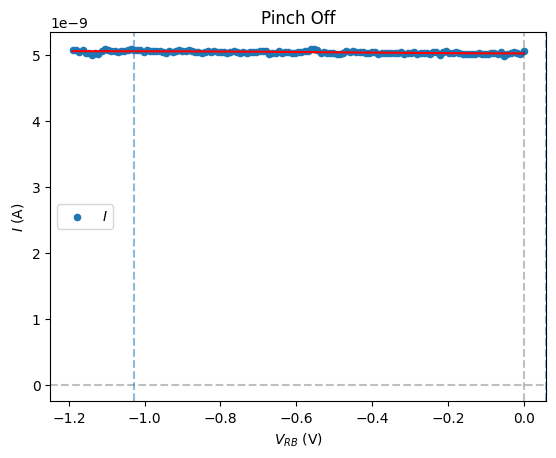

In [21]:
max_V = device_info['Saturation']
min_V = device_info['Turn On']

# sweep_STL = LinSweep(station.sim900.volt_STL, max_V, 0, N, 0.01, get_after_set=True)
# sweep_P = LinSweep(station.sim900.volt_P, max_V, 0, N, 0.01, get_after_set=True)
sweep_LB = LinSweep(station.sim900.volt_LB, max_V, min_V, N, 0.01, get_after_set=True)
sweep_RB = LinSweep(station.sim900.volt_RB, max_V, min_V, N, 0.01, get_after_set=True)
sweep_STR = LinSweep(station.sim900.volt_STR, max_V, min_V, N, 0.01, get_after_set=True)

gate_sweeps = [
    # sweep_STL,
    # sweep_P, 
    sweep_STR,
    sweep_LB, 
    sweep_RB,
]

def fit_data():
    # Load last measurement & convert to current
    dataset = qcodes.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()
    print(df)
    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(sensitivity).subtract(IBias) # sensitivity
    print(df_current)

    # Plot current v.s. param being swept
    axes = df_current.plot.scatter(y='agilent_current', x=f'{str(sweep._param)}', linewidth=1, s=20, label=r'$I$')
    axes.axhline(y=0, color='k', alpha=0.25, linestyle='--')
    axes.axvline(x=0, color='k', alpha=0.25, linestyle='--')
    axes.set_ylabel(r'$I$ (A)')
    axes.set_xlabel(r'$V_{{{gate}}}$ (V)'.format(gate=str(sweep._param).split('_')[-1]))
    axes.set_title('Pinch Off')

    # Fit and get fit params
    X = df_current[f'{str(sweep._param)}']
    Y = df_current['agilent_current']

    guess = (-5e-9,-100,device_info['Turn On'],5e-9)
    fit_params, fit_cov = scipy.optimize.curve_fit(sigmoid_fit, X, Y, guess)
    a, b, x0, y0 = fit_params

    plt.plot(X, sigmoid_fit(X, a,b,x0,y0), 'r-', label='Fit')
    axes.axvline(x=x0 - np.sqrt(8) / b, alpha=0.5, linestyle='--')
    axes.axvline(x=x0 + np.sqrt(8) / b,alpha=0.5, linestyle='--')

    V_pinchoff = min(
        np.abs(x0 - np.sqrt(8) / b),
        np.abs(x0 + np.sqrt(8) / b)
    )
    V_pinchoff_width = round(2 * np.sqrt(8) / b,3)

    device_info[str(sweep._param).split('_')[-1]]['Pinch Off'] = V_pinchoff
    device_info[str(sweep._param).split('_')[-1]]['Width'] = V_pinchoff_width #V

    print(f"Fit function: {sigmoid_fit.__name__}")
    print(f"Width of sigmoid: {V_pinchoff_width} V")
    print(f"{str(sweep._param).split('_')[-1]} Pinch off: {V_pinchoff} V")

def min_current():
    I = sensitivity * station.agilent.volt()

    I_threshold = min_current_threshold / 10# A
    return np.abs(I) < I_threshold
    
for sweep in (gate_sweeps):
    print(f"Pinching off {str(sweep._param).split('_')[-1]}")
    pinch_off = dond(
        sweep,
        station.agilent.volt, 
        # do_plot=True, 
        # show_progress=True, 
        # use_threads=False,
        break_condition=min_current,
        exit_actions=[fit_data],
        measurement_name='{} Pinch Off'.format(str(sweep._param).split('_')[-1]),
        exp=initialization_exp
    )
    station.sim900.set_smooth({str(sweep._param).split('_')[-1]: max_V})

## 3. Barrier Barrier Sweep

In [ ]:
station.sim900.set_smooth({'volt_STL': device_info['STL']['Pinch Off']})
station.sim900.set_smooth({'volt_P': device_info['P']['Pinch Off']})
station.sim900.set_smooth({'volt_STR': device_info['STR']['Pinch Off']})

N = 20
sweep_LB = LinSweep(station.sim900.volt_LB, device_info['LB']['Pinch Off'], device_info['LB']['Width'], N, 0.01, get_after_set=True)
sweep_RB = LinSweep(station.sim900.volt_RB, device_info['RB']['Pinch Off'], device_info['RB']['Width'], N, 0.01, get_after_set=True)

def inference_model():
    # Once BB sweep has been completed, inference the CSD model to extract whether there are any single dot locations
    # of high enough accuracy
    dataset = qcodes.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()
    print(df)
    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(sensitivity).subtract(IBias) # sensitivity
    print(df_current)
    
    print("Done 2D BB Sweep")
    device_info['LB']['Optimal'] = 0
    device_info['RB']['Optimal'] = 0

BB_sweep = dond(
    sweep_LB,
    sweep_RB,
    station.agilent.volt, 
    # do_plot=True, 
    # show_progress=True, 
    # use_threads=True,
    exit_actions=[inference_model],
    measurement_name='Barrier Barrier Sweep',
    exp=initialization_exp
)

## 4. Coulomb Oscillations

In [ ]:
station.sim900.set_smooth({'volt_LB': device_info['LB']['Optimal']})
station.sim900.set_smooth({'volt_RB': device_info['RB']['Optimal']})

N = 20
sweep_P = LinSweep(station.sim900.volt_P, device_info['P']['Pinch Off'], 0, N, 0.01, get_after_set=True)

def fit():
    # Check for enough colomb oscillations
    dataset = qcodes.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()
    print(df)
    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(sensitivity).subtract(IBias) # sensitivity
    print(df_current)
    print("Done plunger sweep")

BB_sweep = dond(
    sweep_P,
    station.agilent.volt, 
    # do_plot=True, 
    # show_progress=True, 
    # use_threads=True,
    exit_actions=[fit],
    measurement_name='Plunger Sweep',
    exp=initialization_exp
)

## 5. Coulomb Diamonds

In [ ]:
station.sim900.set_smooth({'volt_STL': device_info['STL']['Pinch Off']})
station.sim900.set_smooth({'volt_STR': device_info['STR']['Pinch Off']})
station.sim900.set_smooth({'volt_LB': device_info['LB']['Optimal']})
station.sim900.set_smooth({'volt_RB': device_info['RB']['Optimal']})

N=20
sweep_P = LinSweep(station.sim900.volt_P, 0, device_info['Saturation'], N, 0.01, get_after_set=True)
sweep_S = LinSweep(station.sim900.volt_S, -VBias, VBias, 0.01, get_after_set=True)

def extract():
    # extract whatever needed from coulomb diamonds
    dataset = qcodes.load_last_experiment().last_data_set()
    df = dataset.to_pandas_dataframe().reset_index()
    print(df)
    df_current = df.copy()
    df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
    df_current.iloc[:,-1] = df_current.iloc[:,-1].mul(sensitivity).subtract(IBias) # sensitivity
    print(df_current)
    print("Done CD sweep.")

CD_sweep = dond(
    sweep_P,
    sweep_S,
    station.agilent.volt, 
    # do_plot=True, 
    # show_progress=True, 
    # use_threads=True,
    exit_actions=[extract],
    measurement_name='Coulomb Diamonds',
    exp=initialization_exp
)

## 6. Reset Device Voltages

In [ ]:
station.sim900.set_smooth({
    'S': 0,
    'STL': 0,
    'LB': 0,
    'P': 0,
    'RB': 0,
    'STR':0
})

# IGNORE BELOW, EXPERIMENTATION!

In [3]:

# Define a function to generate response variable y based on the given formula
def current(X):
    y = (1/(1+np.exp(20*X[:,0]-5))) + (1/(1+np.exp(20*X[:,1]-5))) + 0.01 * np.random.randn(len(X[:,0]))
    return y

def P_peak(X):
    """
    Generate a Gaussian peak centered at (1, 1).

    Parameters:
        X (array-like): Array of 2D coordinates.

    Returns:
        array-like: Values of the Gaussian peak at the given coordinates.
    """
    # Center of the Gaussian peak
    peak_center = np.array([0.25, .25])

    # Width of the Gaussian peak (adjust as needed)
    sigma = 0.1

    # Calculate the squared distance from each point to the peak center
    dist_sq = np.sum((X - peak_center)**2, axis=1)

    # Evaluate the Gaussian peak
    peak_values = np.exp(-dist_sq / (2 * sigma**2))

    return peak_values

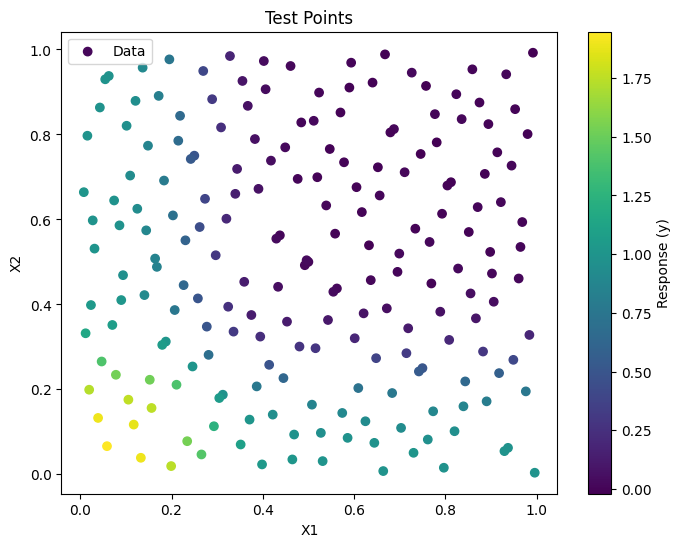

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[[0.44221106 0.44221106]
 [0.43530151 0.43530151]
 [0.42493719 0.50219849]
 [0.41991206 0.53988693]
 [0.51036432 0.43184673]
 [0.54271357 0.42211055]
 [0.39981156 0.65232412]
 [0.65232412 0.39981156]
 [0.43200377 0.43200377]
 [0.90169598 0.40420854]
 [0.40625    0.90625   ]
 [0.44362437 0.44362437]
 [0.40672111 0.56940955]
 [0.60686244 0.42171796]
 [0.53140704 0.41834171]
 [0.41865578 0.71576633]
 [0.43184673 0.47895729]
 [0.42124686 0.53509736]
 [0.68247487 0.39918342]
 [0.46458857 0.41889133]
 [0.3959642  0.56980214]
 [0.56940955 0.40672111]
 [0.39718122 0.68172896]
 [0.68172896 0.39718122]
 [0.42870603 0.42870603]
 [0.87401853 0.41924466]
 [0.40303078 0.84021671]
 [0.44107255 0.44107255]
 [0.4435066  0.4435066 ]
 [0.45014133 0.45014133]
 [0.42878455 0.42878455]
 [0.42352387 0.50141332]
 [0.4167321  0.53796325]
 [0.48928235 0.41327732]
 [0.52123901 0.4037767 ]
 [0.41445509 0.48653423]
 [0.49607412 0.41127513]
 [0.40161746 0.52253455]
 [0.41908763 0.61145572]
 [0.61192682 0.40982255]


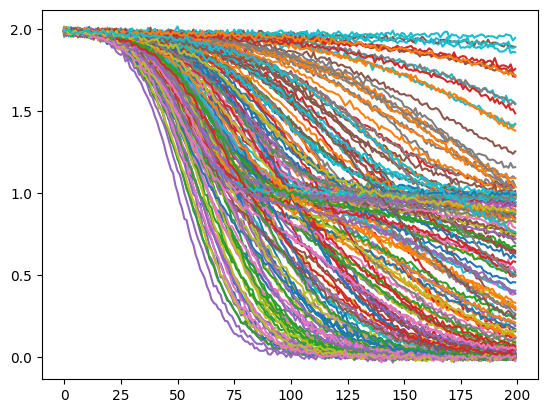

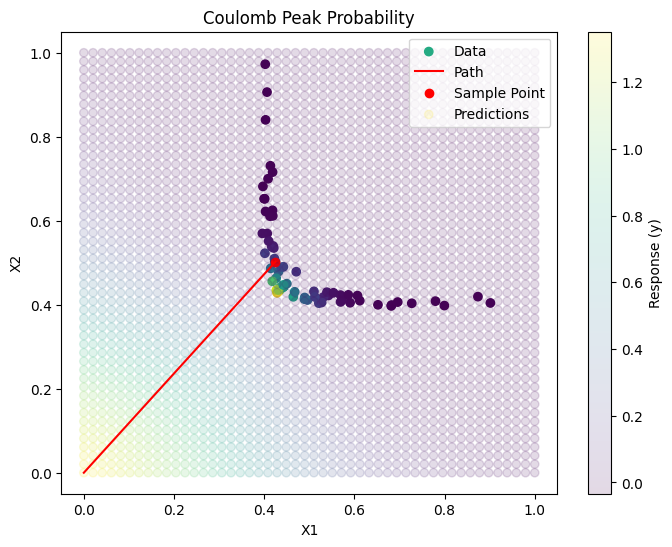

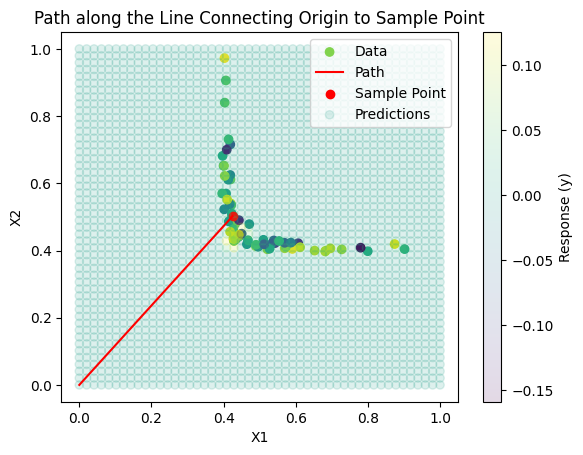

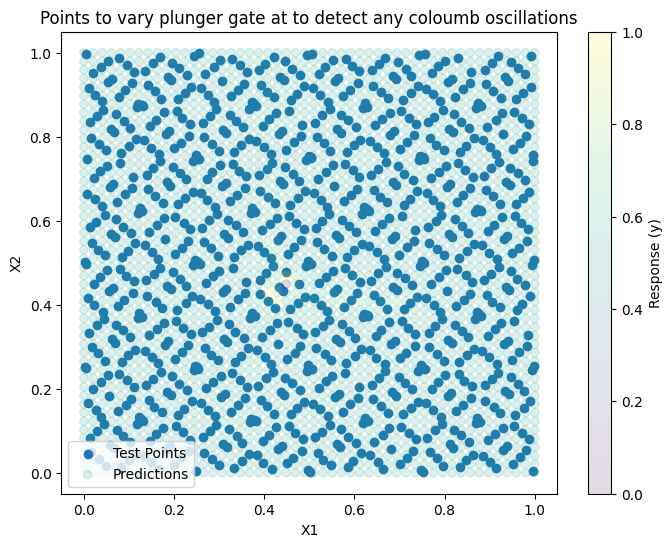

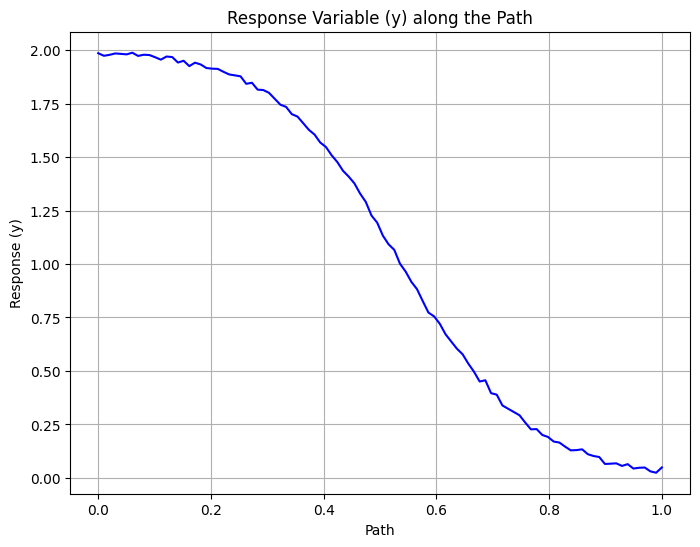

In [141]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from scipy.spatial import Delaunay

# Set the number of points in the sequence
num_points = 200

distribution = cp.Iid(cp.Uniform(0, 1), 2)
samples = distribution.sample(num_points, rule="sobol")

X = samples.T


# Plot the path on the 2D plot
plt.figure(figsize=(8, 6))
# plt.scatter(Xold[:, 0], Xold[:, 1], c=yold, cmap='viridis', label='Data')

plt.scatter(X[:, 0], X[:, 1], c=current(X), cmap='viridis', label='Data')
# plt.plot(path_points[:, 0], path_points[:, 1], color='red', label='Path')
# plt.scatter(sample_point[0], sample_point[1], color='red', label='Sample Point')
# plt.scatter(X_pred[:, 0], X_pred[:, 1], c=y_pred_peak, cmap='viridis', alpha=0.15, label='Predictions')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Test Points')
plt.colorbar(label='Response (y)')
plt.legend()
plt.show()


# Generate synthetic data with response based on the given formula
y = current(X)

# Define the threshold for minimum y value
threshold = 0.05

# List to store indices of points to keep
indices_to_keep = []

# Iterate through each point in samples
for i in range(X.shape[0]):
    # Calculate the path along the line connecting the origin to the (X, Y) point
    path = np.linspace(0, 1, num_points)
    path_points = X[i] * path[:, None]

    # Evaluate the path for y
    path_y = current(path_points)
    plt.plot(path_y)

    # Calculate the minimum value of y along the path
    min_y = np.min(path_y)

    # Check if the minimum value of y is below the threshold
    if min_y <= threshold:
            # Find the index of the last element greater than or equal to the threshold
        index = len(path_y) - np.argmax(path_y[::-1] >= threshold) 

        # Trim the array
        path_y = path_y[:index+1]
        # Find the index of the first point below the threshold
        index_below_threshold = np.argwhere(path_y<threshold).max()

        # Set the sample point (X, Y) to the coordinates of that point
        X[i] = path_points[index_below_threshold]
        y[i] = path_y[index_below_threshold]
    # else:
        indices_to_keep.append(i)

# Keep only the sample points with minimum y below the threshold
Xold = X
yold = y
X = X[indices_to_keep]
y = y[indices_to_keep]


# Define the Gaussian process kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
kernel = Matern(nu=5/2)

# Create Gaussian process regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
gp_peak = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_peak.fit(X,P_peak(X))

# Fit the Gaussian process model to the data
gp.fit(X, y)
print(X,y)

# Define grid of points to predict over
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
X_pred = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

# Make predictions with the Gaussian process model
y_pred, sigma = gp.predict(X_pred, return_std=True)
y_pred_peak, sigma = gp_peak.predict(X_pred, return_std=True)

# Normalize the predicted values between 0 and 1
y_pred_normalized = (y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred))

distribution = cp.Iid(cp.Uniform(0, 1), 2)
samples = distribution.sample(1000, rule="sobol").T
# Iterate through each point in samples
indices_to_keep = []
for i in range(samples.shape[0]):
    predicted = gp.predict([samples[i]])
    if (predicted - np.min(y_pred))/(np.max(y_pred) - np.min(y_pred))> 0.5 and (predicted - np.min(y_pred))/(np.max(y_pred) - np.min(y_pred)) < 0.75:
        indices_to_keep.append(i)
# for i in range(samples.shape[0]):
#     predicted = gp_peak.predict([samples[i]])
#     if (predicted - np.min(y_pred_peak))/(np.max(y_pred_peak) - np.min(y_pred))> 0.55 :
#         indices_to_keep.append(i)

good_samples = samples[indices_to_keep]


# Select one sample point
sample_index = 2
sample_point = X[sample_index]

# Define the number of points along the path
num_path_points = 100

# Calculate the path along the line connecting the origin to the sample point
path = np.linspace(0, 1, num_path_points)
path_points = sample_point * path[:, None]

# Calculate the corresponding y values along the path
path_y = current(path_points)

# Plot the path on the 2D plot
plt.figure(figsize=(8, 6))
# plt.scatter(Xold[:, 0], Xold[:, 1], c=yold, cmap='viridis', label='Data')

plt.scatter(X[:, 0], X[:, 1], c=P_peak(X), cmap='viridis', label='Data')
plt.plot(path_points[:, 0], path_points[:, 1], color='red', label='Path')
plt.scatter(sample_point[0], sample_point[1], color='red', label='Sample Point')
plt.scatter(X_pred[:, 0], X_pred[:, 1], c=y_pred_peak, cmap='viridis', alpha=0.15, label='Predictions')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Coulomb Peak Probability')
plt.colorbar(label='Response (y)')
plt.legend()
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Data')
plt.plot(path_points[:, 0], path_points[:, 1], color='red', label='Path')
plt.scatter(sample_point[0], sample_point[1], color='red', label='Sample Point')
plt.scatter(X_pred[:, 0], X_pred[:, 1], c=y_pred, cmap='viridis', alpha=0.15, label='Predictions')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Path along the Line Connecting Origin to Sample Point')
plt.colorbar(label='Response (y)')
plt.legend()
plt.show()

# Plot the path on the 2D plot
plt.figure(figsize=(8, 6))
plt.scatter(good_samples[:, 0], good_samples[:, 1], label='Test Points')
plt.scatter(X_pred[:, 0], X_pred[:, 1], c=y_pred_normalized, cmap='viridis', alpha=0.15, label='Predictions')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Points to vary plunger gate at to detect any coloumb oscillations')
plt.colorbar(label='Response (y)')
plt.legend()
plt.show()

# Plot the response y along the path
plt.figure(figsize=(8, 6))
plt.plot(path, path_y, color='blue')
plt.xlabel('Path')
plt.ylabel('Response (y)')
plt.title('Response Variable (y) along the Path')
plt.grid(True)
plt.show()


[[0.44221106 0.44221106]
 [0.43530151 0.43530151]
 [0.42493719 0.50219849]
 [0.41991206 0.53988693]
 [0.51036432 0.43184673]
 [0.54271357 0.42211055]
 [0.39981156 0.65232412]
 [0.65232412 0.39981156]
 [0.43200377 0.43200377]
 [0.90169598 0.40420854]
 [0.40625    0.90625   ]
 [0.44362437 0.44362437]
 [0.40672111 0.56940955]
 [0.60686244 0.42171796]
 [0.53140704 0.41834171]
 [0.41865578 0.71576633]
 [0.43184673 0.47895729]
 [0.42124686 0.53509736]
 [0.68247487 0.39918342]
 [0.46458857 0.41889133]
 [0.3959642  0.56980214]
 [0.56940955 0.40672111]
 [0.39718122 0.68172896]
 [0.68172896 0.39718122]
 [0.42870603 0.42870603]
 [0.87401853 0.41924466]
 [0.40303078 0.84021671]
 [0.44107255 0.44107255]
 [0.4435066  0.4435066 ]
 [0.45014133 0.45014133]
 [0.42878455 0.42878455]
 [0.42352387 0.50141332]
 [0.4167321  0.53796325]
 [0.48928235 0.41327732]
 [0.52123901 0.4037767 ]
 [0.41445509 0.48653423]
 [0.49607412 0.41127513]
 [0.40161746 0.52253455]
 [0.41908763 0.61145572]
 [0.61192682 0.40982255]


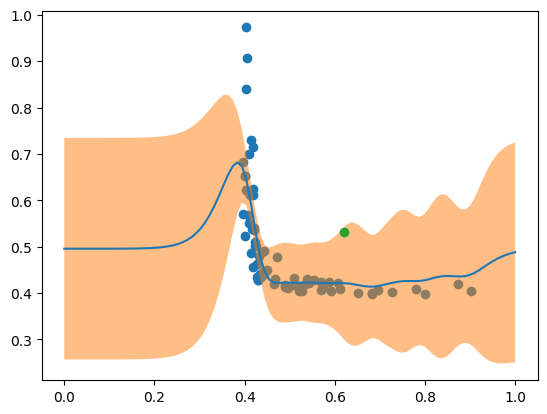

In [150]:
gp = GaussianProcessRegressor(kernel=Matern(nu=5/2), alpha=1, n_restarts_optimizer=10, normalize_y=True)
# X = np.concatenate((X, [[1,0],[1,0.1],[1,0.2],[1,0.3]]))
# X = np.concatenate((X, [[0,1],[0.1,1],[0.2,1],[0.3,1]]))
print(X)
gp.fit(np.atleast_2d(X[:,0]).T, X[:,1])
x = np.linspace(0.,1,100)
# plt.plot(x,f(x))
y_pred, sigma = gp.predict(np.atleast_2d(x).T, return_std=True)
plt.scatter(X[:, 0], X[:, 1], label='Data')
plt.plot(x,y_pred)
plt.fill_between(x, y_pred- 1.96 * sigma, y_pred + 1.96 * sigma,alpha=0.5)

random_x = np.random.rand(1)
samples = gp.sample_y(np.atleast_2d(random_x).T, n_samples=1)

plt.scatter(np.atleast_2d(random_x).T,samples)
plt.show()